This code models the movement of two servos one over the other, so that we can recover the true direction of the laser mounted on the second axis. Notice that this is different from a laser with two degrees of freedom located in at the origin of the world coordinates

In [1]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

import cv2

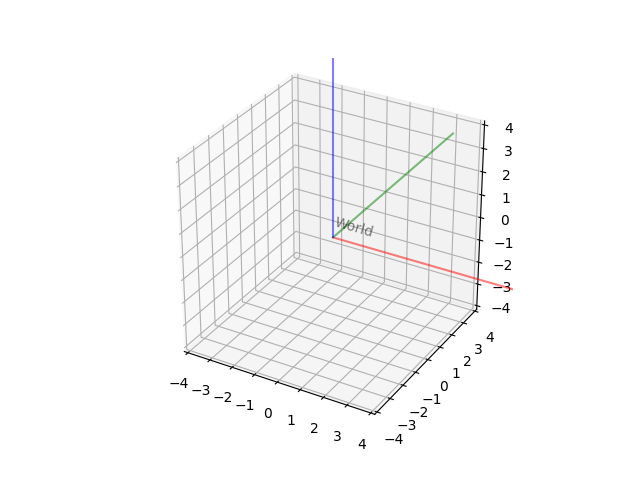

In [2]:
def plot_coord_sys(M_world_sys, scale, sys_name, ax, alpha):
    # Define axes in sys-coord_system
    xyz_s = np.array([[0, 0, 0],[scale, 0, 0], [0, 0, 0],[0, scale, 0], [0, 0, 0],[0, 0, scale]]).T

    # prepare to plot: homogeneous coords:
    xyz1_s = np.row_stack((xyz_s,np.ones((1,xyz_s.shape[1]))))

    # convert to world coords:
    xyz1_w = M_world_sys.dot(xyz1_s)

    # plot axes: x->red, y->green, z->blue.
    ax.plot(xyz1_w[0,:2], xyz1_w[1,:2], xyz1_w[2,:2], color='red', alpha=alpha)
    ax.plot(xyz1_w[0,2:4], xyz1_w[1,2:4], xyz1_w[2,2:4], color='green', alpha=alpha)
    ax.plot(xyz1_w[0,4:], xyz1_w[1,4:], xyz1_w[2,4:], color='blue', alpha=alpha)
    ax.text(xyz1_w[0,0], xyz1_w[1,0], xyz1_w[2,0], sys_name, 'x', color='black', alpha=alpha)
    
def make_figure(x_lim, y_lim, z_lim):
    ax = plt.figure().add_subplot(projection='3d')
    plt.gca().set_aspect('equal', adjustable='box')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_zlim(z_lim)

    return ax

# test transformation matrix:
M_world_sys = np.eye(4)
    
# define figure:
ax = make_figure([-4,4], [-4,4], [-4,4])
plot_coord_sys(M_world_sys,10,'World', ax, 0.5)

plt.show()

Now we define the Laser base coordinate system:

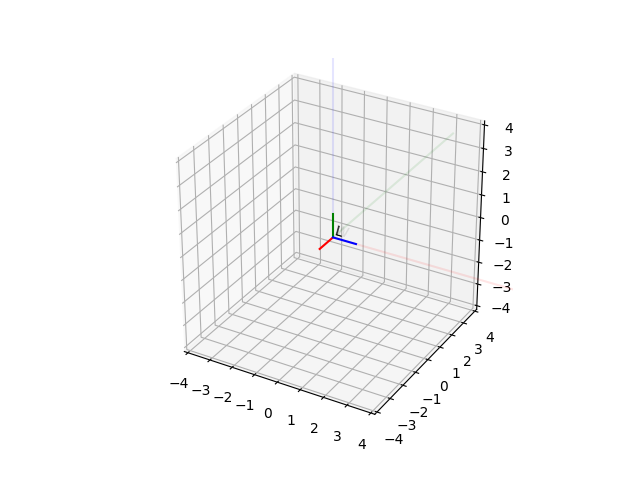

[[ 0.  0.  1.]
 [-1.  0.  0.]
 [ 0.  1.  0.]]
(3,)
(3,)


In [3]:
# the laser has Z in the negative direction:s
M_W_L = np.eye(4)
M_W_L[:3,0] = np.array([0,-1,0])
M_W_L[:3,1] = np.array([0,0,1])
M_W_L[:3,2] = np.array([1,0,0])

# define figure:
ax = make_figure([-4,4], [-4,4], [-4,4])
plot_coord_sys(M_world_sys,10,'W', ax, 0.1)
plot_coord_sys(M_W_L,1,'L', ax, 1)

plt.show()
print(M_W_L[:3,:3])
print(np.array([0,-1,0]).shape)
print(M_W_L[:3,0].shape)

interactive(children=(IntSlider(value=0, description='theta_deg', max=90, min=-90, step=5), IntSlider(value=0,…

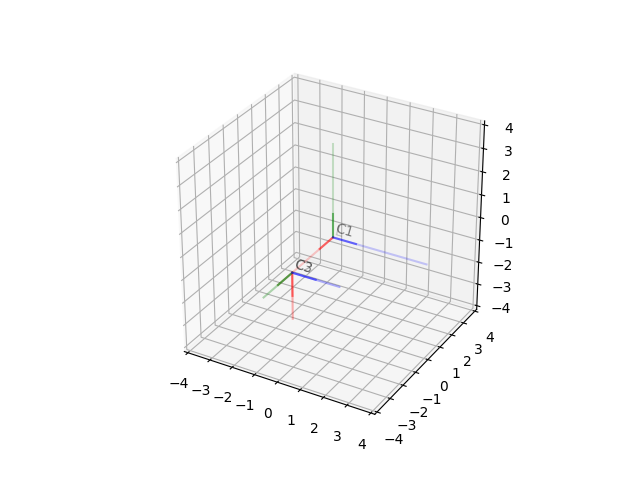

In [8]:
# define figure:
ax = make_figure([-4,4], [-4,4], [-4,4])

def make_C1(theta_deg):
    M_L_C1 = np.eye(4)
    M_L_C1[:3,:3], _ = cv2.Rodrigues(np.array([0,np.deg2rad(theta_deg),0]))
    return M_L_C1

def make_C2(Tx):
    M_C1_C2 = np.eye(4)
    #R
    M_C1_C2[:3,0] = np.array([0,-1,0])
    M_C1_C2[:3,1] = np.array([1,0,0])
    M_C1_C2[:3,2] = np.array([0,0,1])
    #T
    M_C1_C2[:3,3] = np.array([Tx,0,0])
    return M_C1_C2

def make_C3(phi_deg):
    M_C2_C3 = np.eye(4)
    M_C2_C3[:3,:3], _ = cv2.Rodrigues(np.array([0,np.deg2rad(phi_deg),0]))
    return M_C2_C3



# plot the rotated coordinate system:
@widgets.interact(theta_deg=(-90, 90, 5), phi_deg=(-90, 90, 5))
def update(theta_deg = 0, phi_deg=0):
    [l.remove() for l in ax.lines]
    [t.remove() for t in ax.texts]

    # update C1 coordinate sys and compute M to the world
    M_L_C1 = make_C1(theta_deg)
    M_W_C1 = M_W_L.dot(M_L_C1)

    # update C2 coordinate sys and compute M to the world
    M_C1_C2 = make_C2(Tx=3)
    M_W_C2 = M_W_C1.dot(M_C1_C2)

    # update C3 coordinate sys and compute M to the world
    M_C2_C3 = make_C3(phi_deg)
    M_W_C3 = M_W_C2.dot(M_C2_C3)
    
    
    # -------------------------------
    # plot
    plot_coord_sys(M_W_L,4,'L', ax, 0.2)
    plot_coord_sys(M_W_C1,1,'C1', ax, 0.5)
    plot_coord_sys(M_W_C2,2,'C2', ax, 0.3)
    plot_coord_sys(M_W_C3,1,'C3', ax, 0.5)

In [ ]:
TODO: 
1. With that we try to specify the U vector in L coordinates, that will help us in the definition of the optimization problem.ProgressBar
2. Ensure that the camera coordinates system is with the direction that we asumed.
3. Check if the servos move with the same logic as in the simulation, if not then compensate and determine why!
   For this point, notice that cv2.Rodrigues assumes positive angle in the clock-wise direction.



SyntaxError: invalid syntax (2965033810.py, line 1)